In [1]:
from google.colab import drive
drive.mount('drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [5]:
%cd '/content/drive/My Drive/DL/plant_seedings_models'
!pwd
!ls


/content/drive/My Drive/DL/plant_seedings_models
/content/drive/My Drive/DL/plant_seedings_models
plant_seedings_VGG16_green_only.h5
plant_seedings_VGG16_green_only_simple_top.h5
plant_seedings_VGG16_green_only_simple_top_with_block5.h5
plant_seedings_VGG16_green_only_with_block5.h5
plant_seedings_VGG16_with_block5.h5


In [0]:
!git clone https://github.com/sergeyvilov/plant_seedings

Cloning into 'plant_seedings'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 4812 (delta 0), reused 15 (delta 0), pack-reused 4796
Receiving objects: 100% (4812/4812), 179.22 MiB | 21.22 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (6430/6430), done.


In [0]:
from keras.preprocessing.image import ImageDataGenerator

import numpy as np


train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'plant_seedings/train',
    target_size = (60,60),
    batch_size = 20,
    class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
    'plant_seedings/validation',
    target_size = (60,60),
    batch_size = 20,
    class_mode = 'categorical')


Using TensorFlow backend.


FileNotFoundError: ignored

In [0]:
from tensorflow.keras.applications import VGG16


import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))


base_dir = '/content/drive/My Drive/DL/plant_seedings/' 
train_dir = os.path.join(base_dir, 'train_validation') 
validation_dir = os.path.join(base_dir, 'test') 
test_dir = os.path.join(base_dir, 'kaggle_test')

datagen = ImageDataGenerator(rescale=1./255) 
batch_size = 20

def get_green(batch):
  for i in range(batch_size):
    batch[i,:,:,1] = np.divide(batch[i,:,:,1],(batch[i,:,:,0]+batch[i,:,:,1]+batch[i,:,:,2]))*255
    batch[i,:,:,0] =batch[i,:,:,1];
    batch[i,:,:,2] = batch[i,:,:,2];
  return batch

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512)) 
  labels = np.zeros(shape=(sample_count, 12))
  generator = datagen.flow_from_directory(
      directory, target_size=(150, 150), batch_size=batch_size, class_mode='categorical', interpolation = 'bicubic')
  i=0
  for inputs_batch, labels_batch in generator:

    features_batch = conv_base.predict(get_green(inputs_batch))
    features[i * batch_size : (i + 1) * batch_size] = features_batch 
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break
  return features, labels

train_features, train_labels = extract_features(train_dir, 1680) 
validation_features, validation_labels = extract_features(validation_dir, 360) 
test_features, test_labels = extract_features(test_dir, 360)

Found 1680 images belonging to 12 classes.
Found 360 images belonging to 12 classes.
Found 360 images belonging to 12 classes.


In [0]:
train_features = np.reshape(train_features, (1680, 4 * 4 * 512)) 
validation_features = np.reshape(validation_features, (360, 4 * 4 * 512)) 
test_features = np.reshape(test_features, (360, 4 * 4 * 512))


In [0]:
generator = datagen.flow_from_directory(
      train_dir, target_size=(60, 60), batch_size=batch_size, class_mode='categorical', interpolation = 'bicubic')
b, l =next(generator)
b.shape

Found 1680 images belonging to 12 classes.


(20, 60, 60, 3)

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
model = models.Sequential()
model.add(layers.Dense(512*4, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(512*2, activation='relu')) 
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dense(128, activation='relu')) 
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(train_features, train_labels, epochs=100,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


In [0]:
# model.save('plant_seedings_VGG16_78acc.h5')
from tensorflow.keras.models import load_model
model = load_model('plant_seedings_VGG16.h5')
model.summary()


In [0]:
# model.save('plant_seedings_VGG16_with_block5.h5')

model.save('/content/drive/My Drive/DL/plant_seedings_models/plant_seedings_VGG16_with_block5_test.h5')

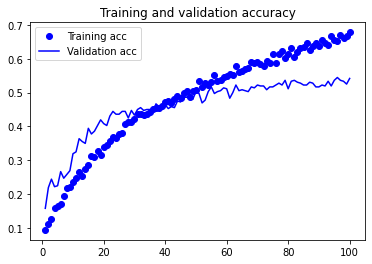

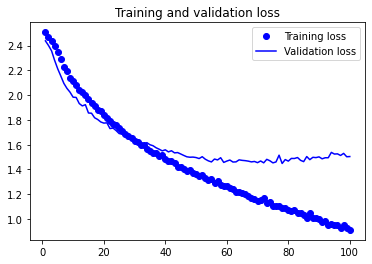

In [0]:

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [24]:
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import load_model
import random as python_random
import numpy as np  
import os

###seeking for reproducibility (to verify)###
# np.random.seed(123)
# python_random.seed(123)
# tensorflow.random.set_seed(1234)
# os.environ['PYTHONHASHSEED'] = '0'

###PREPROCESSING###
base_dir = '/content/drive/My Drive/DL/plant_seedings/' 
train_dir = os.path.join(base_dir, 'train_validation') 
validation_dir = os.path.join(base_dir, 'test') 
test_dir = os.path.join(base_dir, 'kaggle_test')

def preprocessing_function(img):

  # mean_intensity = np.mean(x,axis=(0,1,2))
  # x = x/mean_intensity;

  #return only the green channel
  # green = x[:,:,1]/(x[:,:,1]+x[:,:,2]+x[:,:,0]+0.1)*255;
  # x[:,:,0] = green
  # x[:,:,1] = green
  # x[:,:,2] = green

  #subtract mean values (used in training the original network)
  img[:,:,0] = img[:,:,0] - 103.939
  img[:,:,1] = img[:,:,1] - 116.779
  img[:,:,2] = img[:,:,2] - 123.68

  return img

train_datagen = ImageDataGenerator(
  rotation_range=360, width_shift_range=0, height_shift_range=0, zoom_range=0.15, horizontal_flip = True,
  vertical_flip = True, 
  fill_mode='constant', cval=255, preprocessing_function = preprocessing_function)


test_datagen = ImageDataGenerator(preprocessing_function = preprocessing_function)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150,150),
    interpolation = 'bicubic',
    batch_size = 20,
    class_mode = 'categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    interpolation = 'bicubic',
    batch_size = 20,
    class_mode = 'categorical')


###MODEL###
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.trainable = False

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block4_conv1': 
    set_trainable = True
  if set_trainable: 
    layer.trainable = True
  else:
    layer.trainable = False

model = models.Sequential() 
model.add(conv_base)
model.add(layers.Flatten()) 
# model.add(layers.Dense(512*4, activation='relu', name = 'dense_255'))
# model.add(layers.Dense(64, activation='relu', name = 'dense_256')) 
# model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(1000), activation='relu', name = 'dense_257')) 
# model.add(layers.Dense(256, activation='relu', name = 'dense_258')) 
# model.add(layers.Dense(128, activation='relu', name = 'dense_259')) 
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(12, activation='softmax'))
# model.add(layers.Dense(256, activation='relu')) 
model.add(layers.Dense(12, activation='softmax', name = 'dense_260'))

# model.load_weights('/content/drive/My Drive/DL/plant_seedings_models/test.h5')

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])





Found 4027 images belonging to 12 classes.
Found 723 images belonging to 12 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


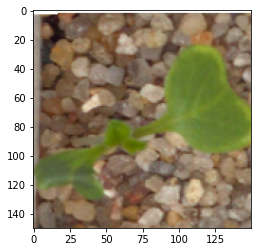

In [0]:
img=next(train_generator)[0][0]
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img)


In [19]:
model = load_model('/content/drive/My Drive/DL/plant_seedings_models/plant_seedings_VGG16_with_block5.h5')
model.load_weights('/content/drive/My Drive/DL/plant_seedings_models/plant_seedings_VGG16_with_block5.h5')

model.summary()


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_47 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_255 (Dense)            (None, 2048)              16779264  
_________________________________________________________________
dense_256 (Dense)            (None, 1024)              2098176   
_________________________________________________________________
dense_257 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_258 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_259 (Dense)            (None, 128)             

In [31]:
from tensorflow.keras.models import load_model
# model.save('/content/drive/My Drive/DL/plant_seedings_models/test.h5')
model2 = load_model('/content/drive/My Drive/DL/plant_seedings_models/plant_seedings_VGG16_with_block5_test.h5')
# for i,layer in enumerate(model2.layers):
        #  if i<=10:
          # model.layers[i].set_weights(layer.get_weights())
# model = load_model('/content/drive/My Drive/DL/plant_seedings_models/plant_seedings_VGG16_with_block5_2.h5')

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5),
                 metrics=['acc'])

history = model.fit_generator( train_generator,
      steps_per_epoch=201,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=36)

Epoch 1/50
201/201 [==============================] - 46s 228ms/step - loss: 0.0680 - acc: 0.9795 - val_loss: 0.3819 - val_acc: 0.9472
Epoch 2/50
201/201 [==============================] - 45s 224ms/step - loss: 0.0653 - acc: 0.9785 - val_loss: 0.3794 - val_acc: 0.9472
Epoch 3/50
201/201 [==============================] - 46s 231ms/step - loss: 0.0583 - acc: 0.9823 - val_loss: 0.3750 - val_acc: 0.9486
Epoch 4/50
201/201 [==============================] - 47s 232ms/step - loss: 0.0679 - acc: 0.9785 - val_loss: 0.3743 - val_acc: 0.9472
Epoch 5/50
201/201 [==============================] - 46s 230ms/step - loss: 0.0573 - acc: 0.9788 - val_loss: 0.3719 - val_acc: 0.9472
Epoch 6/50
 12/201 [>.............................] - ETA: 35s - loss: 0.1289 - acc: 0.9667

KeyboardInterrupt: ignored

In [10]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_256 (Dense)            (None, 1024)              8389632   
_________________________________________________________________
dense_260 (Dense)            (None, 12)                12300     
Total params: 23,116,620
Trainable params: 8,401,932
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# model = load_model('plant_seedings_VGG16_green_only_with_block5.h5')
import os

model = load_model('/content/drive/My Drive/DL/plant_seedings/plant_seedings_VGG16_with_block5.h5')

# (_, _, img_files) = next(os.walk(validation_dir))

# for idx_images in range(len(img_files)):

#   input_img = load_img(input_img_file, target_size=target_size, interpolation="bicubic")

test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    interpolation = 'bicubic',
    batch_size = 1,
    class_mode = 'categorical')

model.predict(next(test_generator))

Found 708 images belonging to 12 classes.


array([[2.0972560e-25, 9.2164247e-19, 1.6438793e-15, 1.0000000e+00,
        4.9391190e-15, 8.4223411e-19, 2.7806919e-18, 1.9810587e-16,
        9.8213750e-15, 3.2277843e-13, 1.8141875e-16, 2.3939612e-19]],
      dtype=float32)

In [0]:
import os
from tensorflow.keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

target_size = (150, 150)

model = load_model('/content/drive/My Drive/DL/plant_seedings_models/plant_seedings_VGG16_with_block5.h5')

base_dir = '/content/drive/My Drive/DL/plant_seedings' 
test_dir = os.path.join(base_dir, 'test') 
validation_dir = os.path.join(base_dir, 'validation') 

class_names = ['Shepherds_Purse', 'Cleavers', 'Loose_Silky-bent', 'Common_Chickweed', 'Scentless_Mayweed',
  'Sugar_beet', 'Black-grass', 'Fat_Hen', 'Small-flowered_Cranesbill', 'Common_wheat', 'Charlock', 'Maize']

class_names.sort()

def preprocessing_function(x):
  x[:,:,0] = x[:,:,0] - 103.939
  x[:,:,1] = x[:,:,1] - 116.779
  x[:,:,2] = x[:,:,2] - 123.68
  return x

error_counter = 0
file_counter = 0

for class_idx in range(len(class_names)):
    class_name = class_names[class_idx]
    class_dir = os.path.join(validation_dir, class_name) 
    (_, _, fnames) = next(os.walk(class_dir))
    for fname in fnames:
      file_counter+=1
      img_file = os.path.join(class_dir, fname) 
      initial_img = load_img(img_file)
      img = img_to_array(initial_img)
      img = preprocessing_function(img)
      img = np.expand_dims(img, 0)
      predicted_class_idx = np.argmax(model.predict(img));
      predicted_class_name = class_names[predicted_class_idx];
      if predicted_class_idx!=class_idx:
        error_counter+=1
        print("Image file name: {}\n Real Class:{}\n Predicted Class:{}\n".format(fname, class_name, predicted_class_name))
        print("Total errors: {} ({:.2f}%)\n".format(error_counter, error_counter/file_counter*100))
        print("{} files processed\n".format(file_counter))

print("{} files processed".format(file_counter))





In [18]:


# model = load_model('/content/drive/My Drive/DL/plant_seedings_models/plant_seedings_VGG16_with_block5_2.h5')

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(150, 150),
    interpolation="bicubic",
    batch_size=1,
    class_mode=None,
    shuffle=False
)

pred=model.predict_generator(test_generator, steps=794)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels = dict([(v,k.replace('_',' ')) for v,k in labels.items()])
predictions = [labels[k] for k in predicted_class_indices]

import pandas as pd
filenames=test_generator.filenames
filenames = [filename.split('/')[-1] for filename in filenames]

results=pd.DataFrame({"file":filenames,
                      "species":predictions})

results.to_csv("/content/drive/My Drive/plant_seedings_results_3.csv",index=False)

Found 794 images belonging to 1 classes.
Instructions for updating:
Please use Model.predict, which supports generators.


In [0]:

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels = dict([(v,k.replace('_',' ')) for v,k in labels.items()])
predictions = [labels[k] for k in predicted_class_indices]

import pandas as pd

filenames=test_generator.filenames
filenames = [filename.split('/')[-1] for filename in filenames]

results=pd.DataFrame({"file":filenames,
                      "species":predictions})

results.to_csv("/content/drive/My Drive/plant_seedings_results_2.csv",index=False)

In [0]:
filenames[0].split('/')[-1]

'0021e90e4.png'